In [1]:
import tensorflow as tf
import numpy
import pickle
from keras.layers import (
    Input,
    TimeDistributed,
    LSTM,
    Dense,
    Input,
    Dense,
    Conv1D,
    Flatten, 
    Embedding,

    
    Dropout)
from keras import Model
import keras
%run constants.py

In [2]:
#Dataset Prep
with open(X_TRAIN_SINGLE_TIMESTEP_RAW, "rb") as f:
        x_train = pickle.load(f)
with open(Y_TRAIN_INPUT_SAVE_FILE, "rb") as f:
        y_train = pickle.load(f)

with open(X_VAL_SINGLE_TIMESTEP_RAW, "rb") as f:
        x_val = pickle.load(f)
with open(Y_VAL_INPUT_SAVE_FILE, "rb") as f:
        y_val = pickle.load(f)

with open(X_TEST_SINGLE_TIMESTEP_RAW, "rb") as f:
        x_test = pickle.load(f)
with open(Y_TEST_INPUT_SAVE_FILE, "rb") as f:
        y_test = pickle.load(f)

x_test_one_timestep = numpy.array(x_test)
x_train_one_timestep = numpy.array(x_train)
x_val_one_timestep = numpy.array(x_val)

In [3]:

flat_list_train_corpora = [x for xs in x_train for x in xs]
flat_list_train_corpora = list(set(flat_list_train_corpora))
from keras.layers import TextVectorization

def create_textvectorisation(lst):
    text_vectorization: TextVectorization = TextVectorization(
        output_mode="int",
        split="whitespace",
        max_tokens=MAX_VOCAB_SIZE,
        output_sequence_length=MAX_SEQUENCE_LENGTH,
    )
    text_vectorization.adapt(lst)
    return text_vectorization


text_vectorization = create_textvectorisation(flat_list_train_corpora)



2022-07-24 15:05:19.018564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 15:05:19.953884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6672 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-07-24 15:05:19.954729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6671 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5


In [4]:

x_test_one_timestep_vec = text_vectorization(x_test_one_timestep)
x_train_one_timestep_vec = text_vectorization(x_train_one_timestep)
x_val_one_timestep_vec = text_vectorization(x_val_one_timestep)

In [5]:
with open(EMBEDDING_MATRIX_SAVE_FILE, "rb") as f:
        embedding_matrix = pickle.load(f)
embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights = [embedding_matrix], trainable=False)

In [6]:
def lstm_model():

  X_indices = Input(shape=(MAX_SEQUENCE_LENGTH,))

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [14]:
NUM_EPOCHS = 30

In [17]:
import tensorflow_models as tfm
train_data_size =  len(x_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE)
num_train_steps = steps_per_epoch * NUM_EPOCHS
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-4

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

model = lstm_model()
adam = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = model.fit(x=x_train_one_timestep_vec, y=y_train,
                                validation_data = (x_val_one_timestep_vec, y_val),
                               epochs=NUM_EPOCHS)

Epoch 1/30
78/78 [==============================] - 9s 59ms/step - loss: 0.6928 - binary_accuracy: 0.5513 - val_loss: 0.6916 - val_binary_accuracy: 0.6058
Epoch 2/30
78/78 [==============================] - 4s 46ms/step - loss: 0.6912 - binary_accuracy: 0.5558 - val_loss: 0.6866 - val_binary_accuracy: 0.5876
Epoch 3/30
78/78 [==============================] - 4s 48ms/step - loss: 0.6877 - binary_accuracy: 0.5562 - val_loss: 0.6832 - val_binary_accuracy: 0.5803
Epoch 4/30
78/78 [==============================] - 4s 48ms/step - loss: 0.6865 - binary_accuracy: 0.5566 - val_loss: 0.6823 - val_binary_accuracy: 0.5839
Epoch 5/30
78/78 [==============================] - 4s 47ms/step - loss: 0.6861 - binary_accuracy: 0.5606 - val_loss: 0.6828 - val_binary_accuracy: 0.5912
Epoch 6/30
78/78 [==============================] - 4s 47ms/step - loss: 0.6861 - binary_accuracy: 0.5602 - val_loss: 0.6880 - val_binary_accuracy: 0.5803
Epoch 7/30
78/78 [==============================] - 4s 48ms/step - los

In [18]:

loss, accuracy = model.evaluate(x= x_test_one_timestep_vec, y= y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

22/22 [==============================] - 0s 19ms/step - loss: 0.6675 - binary_accuracy: 0.5927
Loss: 0.6675203442573547
Accuracy: 0.592700719833374


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


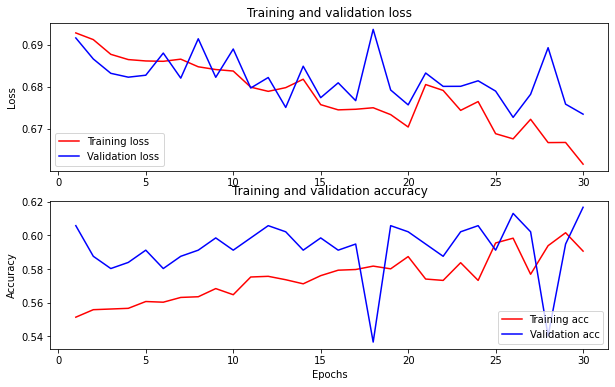

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')